# Stroke Risk Prediction Project

This notebook develops a supervised learning pipeline to predict stroke occurrence using the dataset provided in the `Data` folder. The workflow follows the end-to-end methodology covered in class: exploratory data analysis, feature engineering, preprocessing with transformers and pipelines, model training, hyperparameter tuning, and evaluation.

## Project Hypotheses

1. **Age effect**: As patient age increases, the likelihood of experiencing a stroke rises, even after controlling for cardiovascular risk factors.
2. **Chronic conditions impact**: Individuals with hypertension or heart disease are among the groups most likely to suffer a stroke, making cardiovascular indicators top predictive features.

These hypotheses are testable with the available clinical and demographic attributes and guide the feature engineering and model evaluation steps that follow.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, balanced_accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")

In [ ]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Exploratory Analysis (Univariate)

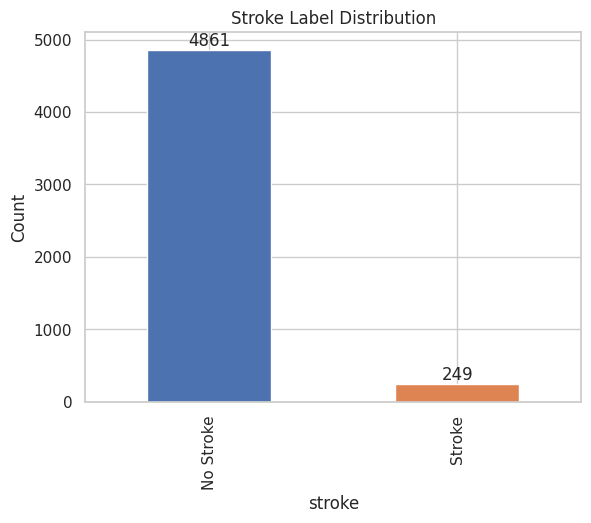

Stroke prevalence: 4.87%


In [ ]:
# Target distribution
stroke_counts = df['stroke'].value_counts().rename(index={0: 'No Stroke', 1: 'Stroke'})
ax = stroke_counts.plot(kind='bar', color=['#4c72b0', '#dd8452'])
ax.set(title='Stroke Label Distribution', ylabel='Count')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.show()

stroke_rate = df['stroke'].mean()
print(f"Stroke prevalence: {stroke_rate:.2%}")

In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
# Basic dataset diagnostics
df_info = pd.DataFrame({
    "dtype": df.dtypes,
    "n_unique": df.nunique(),
    "missing": df.isna().sum(),
    "missing_%": (df.isna().mean() * 100).round(2)
})
df_info

,dtype,n_unique,missing,missing_%
id,int64,5110,0,0.00
gender,object,3,0,0.00
age,float64,104,0,0.00
hypertension,int64,2,0,0.00
heart_disease,int64,2,0,0.00
ever_married,object,2,0,0.00
work_type,object,5,0,0.00
Residence_type,object,2,0,0.00
avg_glucose_level,float64,3979,0,0.00
bmi,float64,418,201,3.93


In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates


np.int64(0)

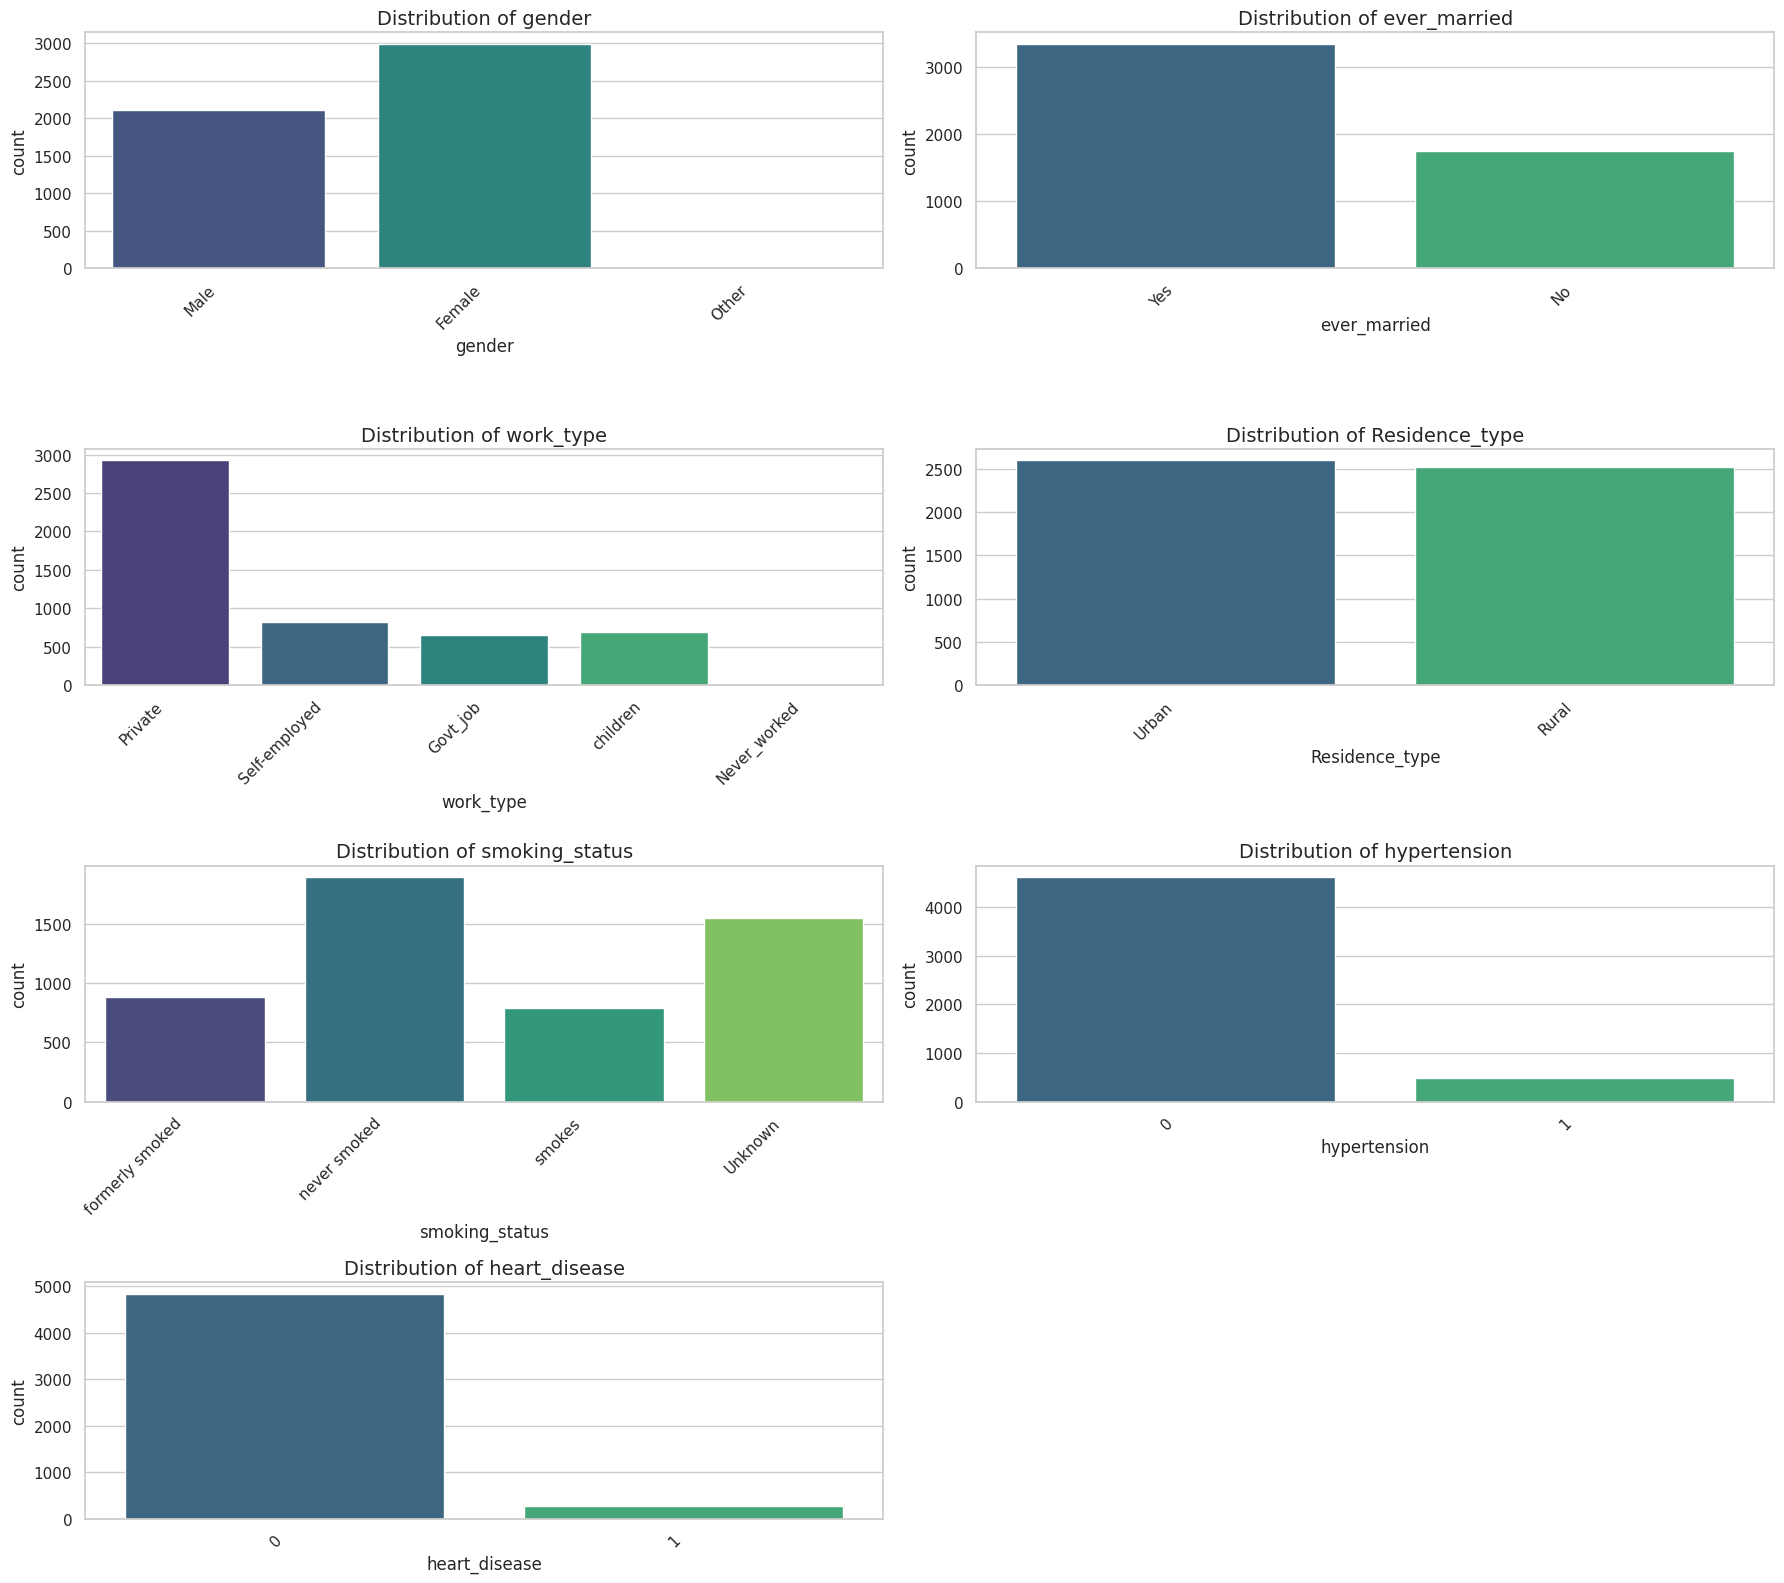

In [ ]:
#Create Bar Charts for categorical variables
categorical_cols = [
    'gender',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
    'hypertension',
    'heart_disease'
]

# Adjust figure size to be taller for 4 rows
# Change subplot grid from (3, 2) to (4, 2)
plt.figure(figsize=(18, 16))
for i, col in enumerate(categorical_cols):
    # FIX: Changed 3 to 4 for the number of rows
    plt.subplot(4, 2, i + 1)
    # Assuming 'sns' (seaborn) and 'df' (your DataFrame) are defined in your environment
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

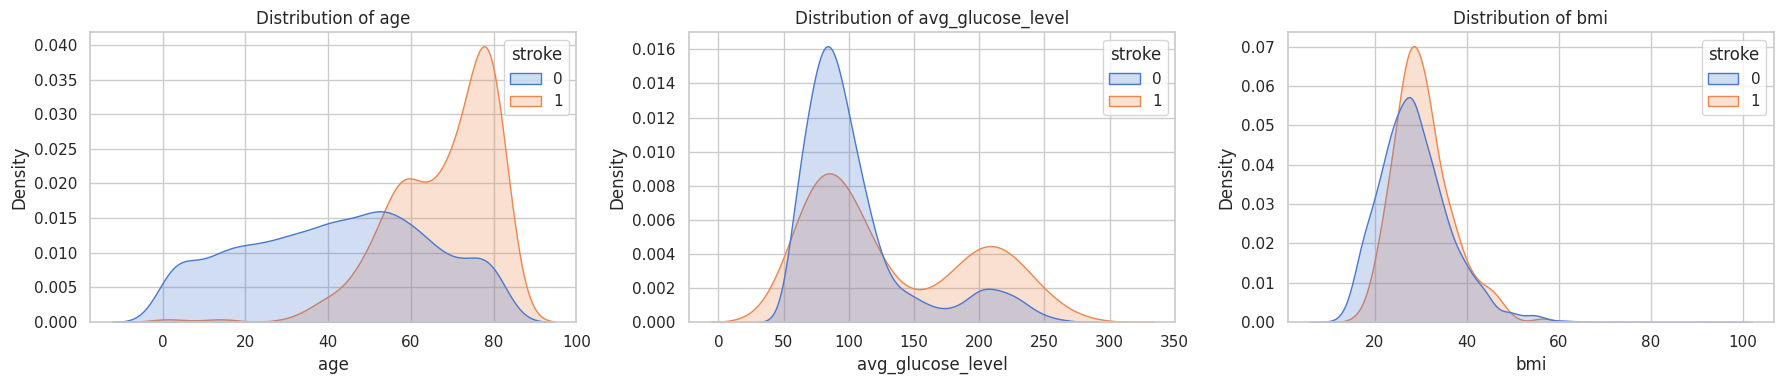

In [ ]:
#Create distributions for numerical variables showing two distribution for stroke = 1 and stroke = 0 with different colours
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

n_num = len(numerical_cols)
fig, axes = plt.subplots(1, n_num, figsize=(6 * n_num, 4))
if n_num == 1:
    axes = [axes]
for ax, col in zip(axes, numerical_cols):
    sns.kdeplot(data=df, x=col, hue='stroke', common_norm=False, ax=ax, fill=True)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

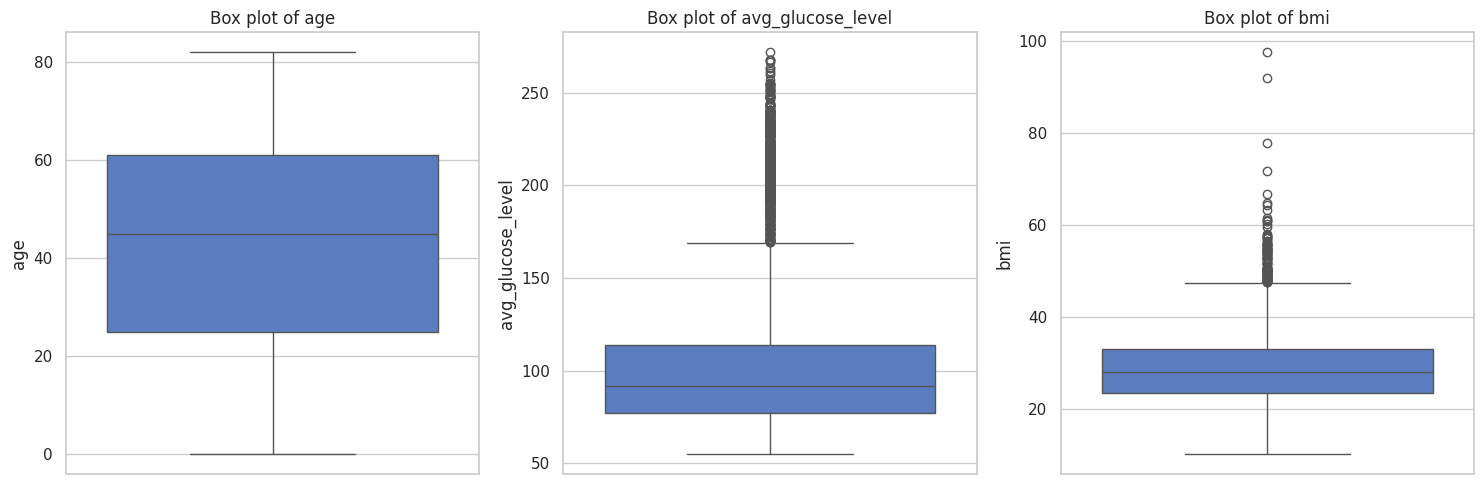

Visual inspection of box plots can help identify outliers. For more rigorous detection, statistical methods like the IQR rule or Z-score could be applied.


In [ ]:
#Check for outliers

numerical_cols = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

print("Visual inspection of box plots can help identify outliers. For more rigorous detection, statistical methods like the IQR rule or Z-score could be applied.")

##Feature Engineering

In [ ]:
# 1. Create a missingness flag for BMI
df['bmi_missing_flag'] = df['bmi'].isna().astype(int)

# 2. Create a Log Transformation for avg_glucose_level and for BMI
# Using log1p to handle potential zero values if they were present, though not strictly needed for these columns as per describe()
df['avg_glucose_level_log'] = np.log1p(df['avg_glucose_level'])
df['bmi_log'] = np.log1p(df['bmi'])

# 3. Check if in the category 'Unknown' of smoking_status there is any stroke=1, and print how many there are
unknown_smoking_stroke_count = df[(df['smoking_status'] == 'Unknown') & (df['stroke'] == 1)].shape[0]
print(f"Count of 'Unknown' smoking_status with stroke=1: {unknown_smoking_stroke_count}")

# Create a missingness flag for 'Unknown' smoking_status, similar to BMI
df['smoking_status_unknown_flag'] = (df['smoking_status'] == 'Unknown').astype(int)

#Drop columns
df = df.drop(columns=['bmi', 'avg_glucose_level'])

# Display the first few rows and updated info to verify changes
print("\nDataFrame after feature engineering:")
display(df.head())
print("\nDataFrame info after feature engineering:")
display(df.info())

Count of 'Unknown' smoking_status with stroke=1: 47

DataFrame after feature engineering:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,bmi_missing_flag,avg_glucose_level_log,bmi_log,smoking_status_unknown_flag
0,9046,Male,67.0,0,1,Yes,Private,Urban,formerly smoked,1,0,5.436731,3.627004,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,never smoked,1,1,5.314240,NaN,0
2,31112,Male,80.0,0,1,Yes,Private,Rural,never smoked,1,0,4.672081,3.511545,0
3,60182,Female,49.0,0,0,Yes,Private,Urban,smokes,1,0,5.148831,3.566712,0
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,never smoked,1,0,5.165471,3.218876,0



DataFrame info after feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5110 non-null   int64  
 1   gender                       5110 non-null   object 
 2   age                          5110 non-null   float64
 3   hypertension                 5110 non-null   int64  
 4   heart_disease                5110 non-null   int64  
 5   ever_married                 5110 non-null   object 
 6   work_type                    5110 non-null   object 
 7   Residence_type               5110 non-null   object 
 8   smoking_status               5110 non-null   object 
 9   stroke                       5110 non-null   int64  
 10  bmi_missing_flag             5110 non-null   int64  
 11  avg_glucose_level_log        5110 non-null   float64
 12  bmi_log                      4909

None

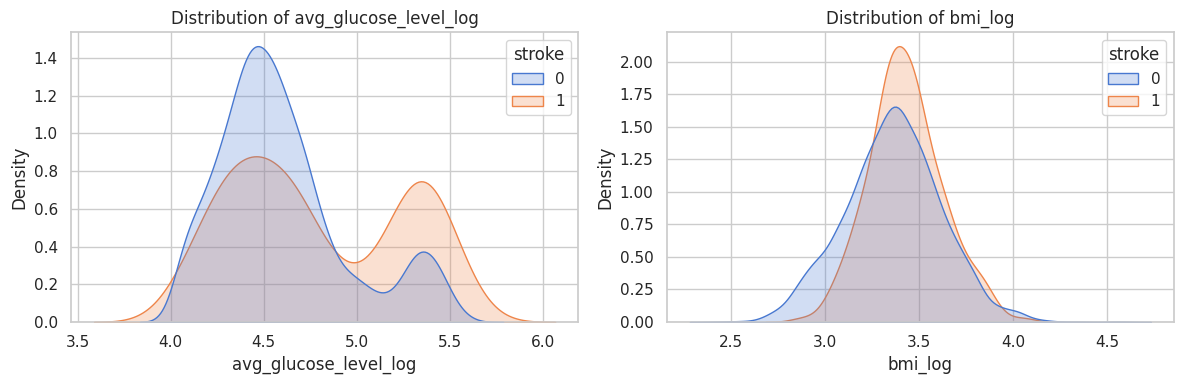

Comparing these distributions to the original ones can indicate the effect of log transformation on reducing skewness and the impact of outliers.


In [ ]:
# Check if the log transformation removed outliers

numerical_cols_transformed = ['avg_glucose_level_log', 'bmi_log']
n_num = len(numerical_cols_transformed)

fig, axes = plt.subplots(1, n_num, figsize=(6 * n_num, 4))

for ax, col in zip(axes, numerical_cols_transformed):
    sns.kdeplot(data=df, x=col, hue='stroke', common_norm=False, ax=ax, fill=True)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

print("Comparing these distributions to the original ones can indicate the effect of log transformation on reducing skewness and the impact of outliers.")

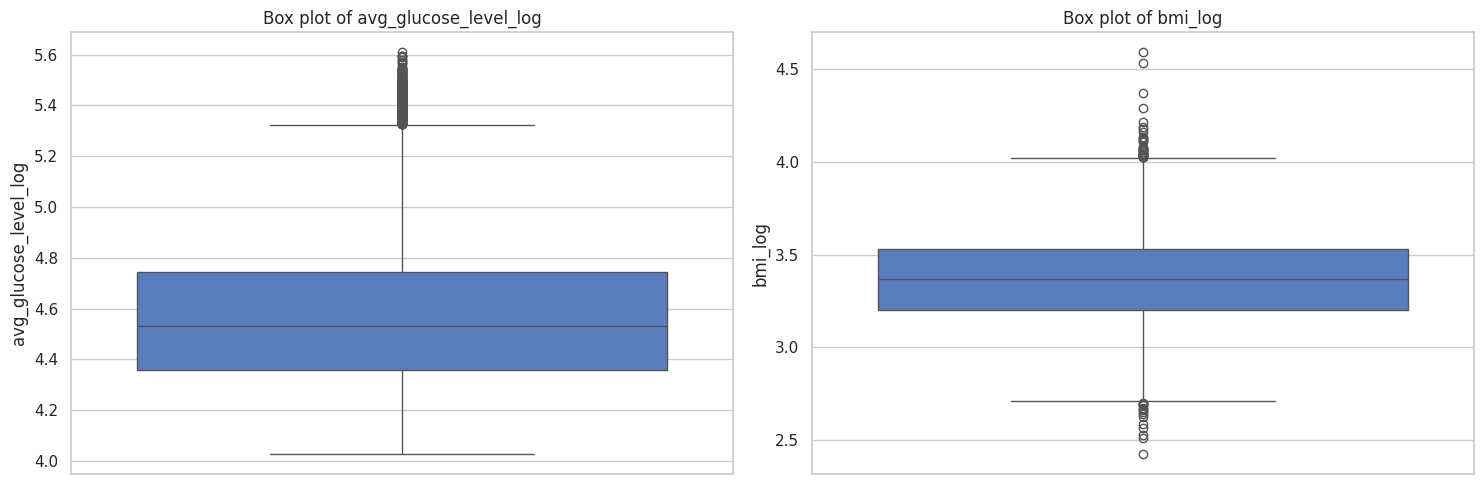

Visual inspection of box plots for log-transformed variables can help identify remaining outliers or confirm outlier reduction.


In [ ]:
numerical_cols_transformed = ['avg_glucose_level_log', 'bmi_log']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols_transformed):
    plt.subplot(1, len(numerical_cols_transformed), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

print("Visual inspection of box plots for log-transformed variables can help identify remaining outliers or confirm outlier reduction.")

##Final Exploratory Analysis - Post feature engineering (Multivariate)

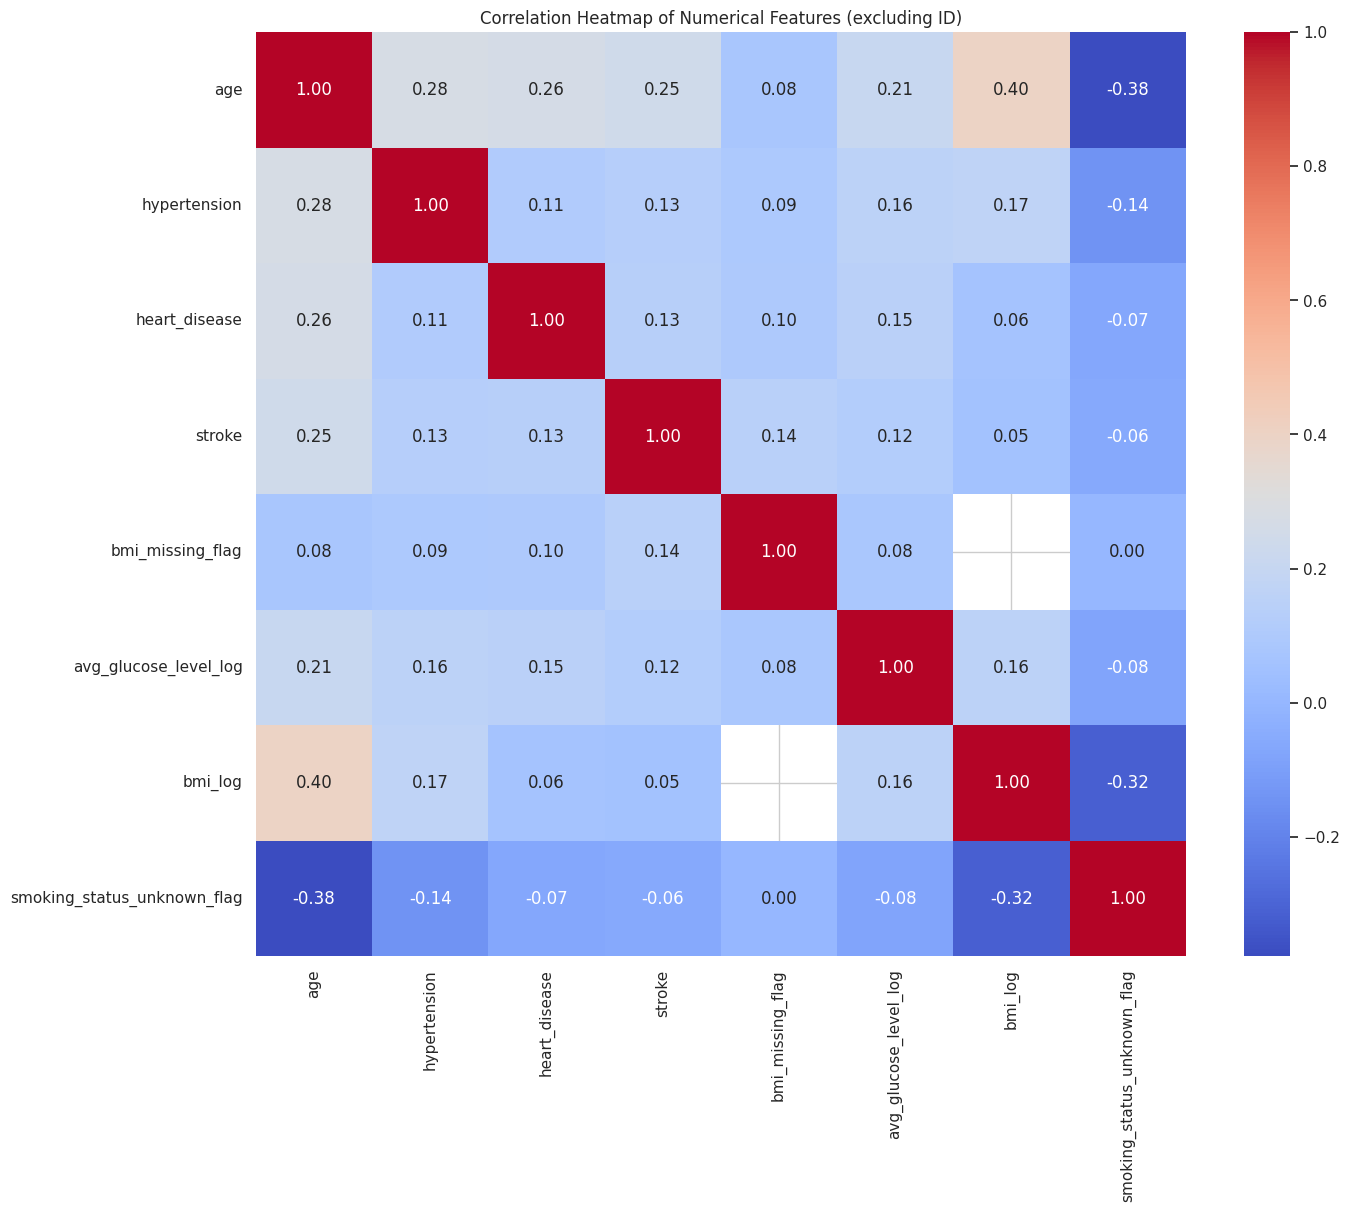

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(15, 12))
# Select numerical columns and drop the 'id' column before calculating correlation
sns.heatmap(df.select_dtypes(include=np.number).drop(columns=['id']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features (excluding ID)')
plt.show()

##Pre-processing

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 1. Drop rows where 'gender' is 'Other'
original_gender_count_other = df[df['gender'] == 'Other'].shape[0]
if original_gender_count_other > 0:
    df = df[df['gender'] != 'Other']
    print(f"Dropped {original_gender_count_other} rows where gender was 'Other'.")
else:
    print("No 'Other' gender category found in the dataset.")

# 2. Make gender binary (Male=1, Female=0)
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# 3. Make ever_married binary (Yes=1, No=0)
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

# 4. Make Residence_type binary (Rural=0, Urban=1)
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})

# 5. DROP ID COLUMN
df_model = df.drop(columns=['id'])

# 6. SPLIT FIRST - before any encoding
X = df_model.drop(columns=['stroke'])
y = df_model['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. NOW encode categorical variables (fit on train only)
categorical_cols_ohe = ['work_type', 'smoking_status']

# Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# FIT on training data ONLY
ohe.fit(X_train[categorical_cols_ohe])

# Transform both train and test
encoded_train = ohe.transform(X_train[categorical_cols_ohe])
encoded_test = ohe.transform(X_test[categorical_cols_ohe])

# Create DataFrames
encoded_train_df = pd.DataFrame(
    encoded_train,
    columns=ohe.get_feature_names_out(categorical_cols_ohe),
    index=X_train.index
)
encoded_test_df = pd.DataFrame(
    encoded_test,
    columns=ohe.get_feature_names_out(categorical_cols_ohe),
    index=X_test.index
)

# Drop original categorical columns and concatenate encoded features
X_train = pd.concat([X_train.drop(columns=categorical_cols_ohe), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols_ohe), encoded_test_df], axis=1)

# 8. Impute missing values (if any remain, e.g., BMI_log)
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)  # Fit on train only

X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Stroke prevalence in Train: {y_train.mean():.2%}")
print(f"Stroke prevalence in Test: {y_test.mean():.2%}")

Dropped 1 rows where gender was 'Other'.
Training features shape: (4087, 19)
Test features shape: (1022, 19)
Stroke prevalence in Train: 4.87%
Stroke prevalence in Test: 4.89%


##Scaling and CV Splitter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve

# Set up CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

##GridSearchCV Setup

We define the pipelines and hyperparameter grids for 5 models:
1.  **Logistic Regression (Baseline)**
2.  **Ridge Logistic Regression**
3.  **Elastic Net Logistic Regression**
4.  **Random Forest**
5.  **Gradient Boosting (XGBoost)**

In [ ]:
# 1. Logistic Regression
pipe_logit = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42))
])
param_logit = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs"]
}

# 2. Ridge (L2)
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty='l2', max_iter=5000, class_weight='balanced', random_state=42))
])
param_ridge = {
    "model__C": [0.01, 0.1, 1, 10], # Smaller C = Stronger Penalty
    "model__solver": ["lbfgs", "liblinear"]
}

# 3. Elastic Net
pipe_elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, class_weight='balanced', random_state=42))
])
param_elastic = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}

# 4. Random Forest
pipe_rf = Pipeline([
    ("model", RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])
param_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [4, 6, 8],
    "model__min_samples_leaf": [2, 5]
}

# 5. XGBoost
pipe_xgb = Pipeline([
    ("model", XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=1))
])
param_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__scale_pos_weight": [scale_pos_weight_value]
}

##Model Training and Selection

We run the grid search for all models and compare their cross-validated ROC AUC, PR AUC, and Recall
scores.

In [ ]:
models = {
    "Logistic Regression": (pipe_logit, param_logit),
    "Ridge Regression": (pipe_ridge, param_ridge),
    "Elastic Net": (pipe_elastic, param_elastic),
    "Random Forest": (pipe_rf, param_rf),
    "XGBoost": (pipe_xgb, param_xgb)
}

results_list = []

print("Running Grid Search...")
print("=" * 80)

for name, (pipeline, params) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        cv=cv,
        scoring={'Recall': 'recall', 'ROC_AUC': 'roc_auc', 'Precision': 'precision'},
        refit=False,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    cv_res = grid.cv_results_
    for i in range(len(cv_res['params'])):
        results_list.append({
            'Model': name,
            'Params': cv_res['params'][i],
            'Mean_Recall': cv_res['mean_test_Recall'][i],
            'Mean_ROC_AUC': cv_res['mean_test_ROC_AUC'][i],
            'Mean_Precision': cv_res['mean_test_Precision'][i]
        })

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by=["Mean_Recall", "Mean_ROC_AUC"], ascending=False).reset_index(drop=True)

print("\n MODEL RANKING (Sorted by Recall)")
display(results_df.head(15))

Running Grid Search...
Training Logistic Regression...
Training Ridge Regression...
Training Elastic Net...
Training Random Forest...
Training XGBoost...

 MODEL RANKING (Sorted by Recall)


,Model,Params,Mean_Recall,Mean_ROC_AUC,Mean_Precision
0,Ridge Regression,"{'model__C': 0.01, 'model__solver': 'liblinear'}",0.834359,0.852807,0.133671
1,Random Forest,"{'model__max_depth': 4, 'model__min_samples_le...",0.819359,0.839333,0.120808
2,Random Forest,"{'model__max_depth': 4, 'model__min_samples_le...",0.819359,0.838597,0.118489
3,Random Forest,"{'model__max_depth': 4, 'model__min_samples_le...",0.819359,0.837873,0.118930
4,Elastic Net,"{'model__C': 0.01, 'model__l1_ratio': 0.2}",0.804359,0.853999,0.140836
5,Random Forest,"{'model__max_depth': 4, 'model__min_samples_le...",0.804359,0.838221,0.119497
6,Elastic Net,"{'model__C': 0.01, 'model__l1_ratio': 0.8}",0.799359,0.856154,0.137812
7,Elastic Net,"{'model__C': 0.01, 'model__l1_ratio': 0.5}",0.799231,0.856362,0.139322
8,Ridge Regression,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.799231,0.853307,0.140652
9,Logistic Regression,"{'model__C': 0.01, 'model__solver': 'lbfgs'}",0.794359,0.852349,0.138982


##Final Evaluation

We select the best model based on CV performance and evaluate it on the held-out test set using multiple metrics: Recall, Precision, F1-score, ROC AUC, Confusion Matric, ROC Curve, PR Curve and Validation Curve.


 ANALYZING CHOSEN MODEL: Ridge Regression
Using Parameters: {'model__C': 0.01, 'model__solver': 'liblinear'}

 TEST SET PERFORMANCE
Recall:       0.8200
Precision:    0.1340
ROC AUC:      0.8331
F1 Score:     0.2303

Generating Validation Curve for stability check...


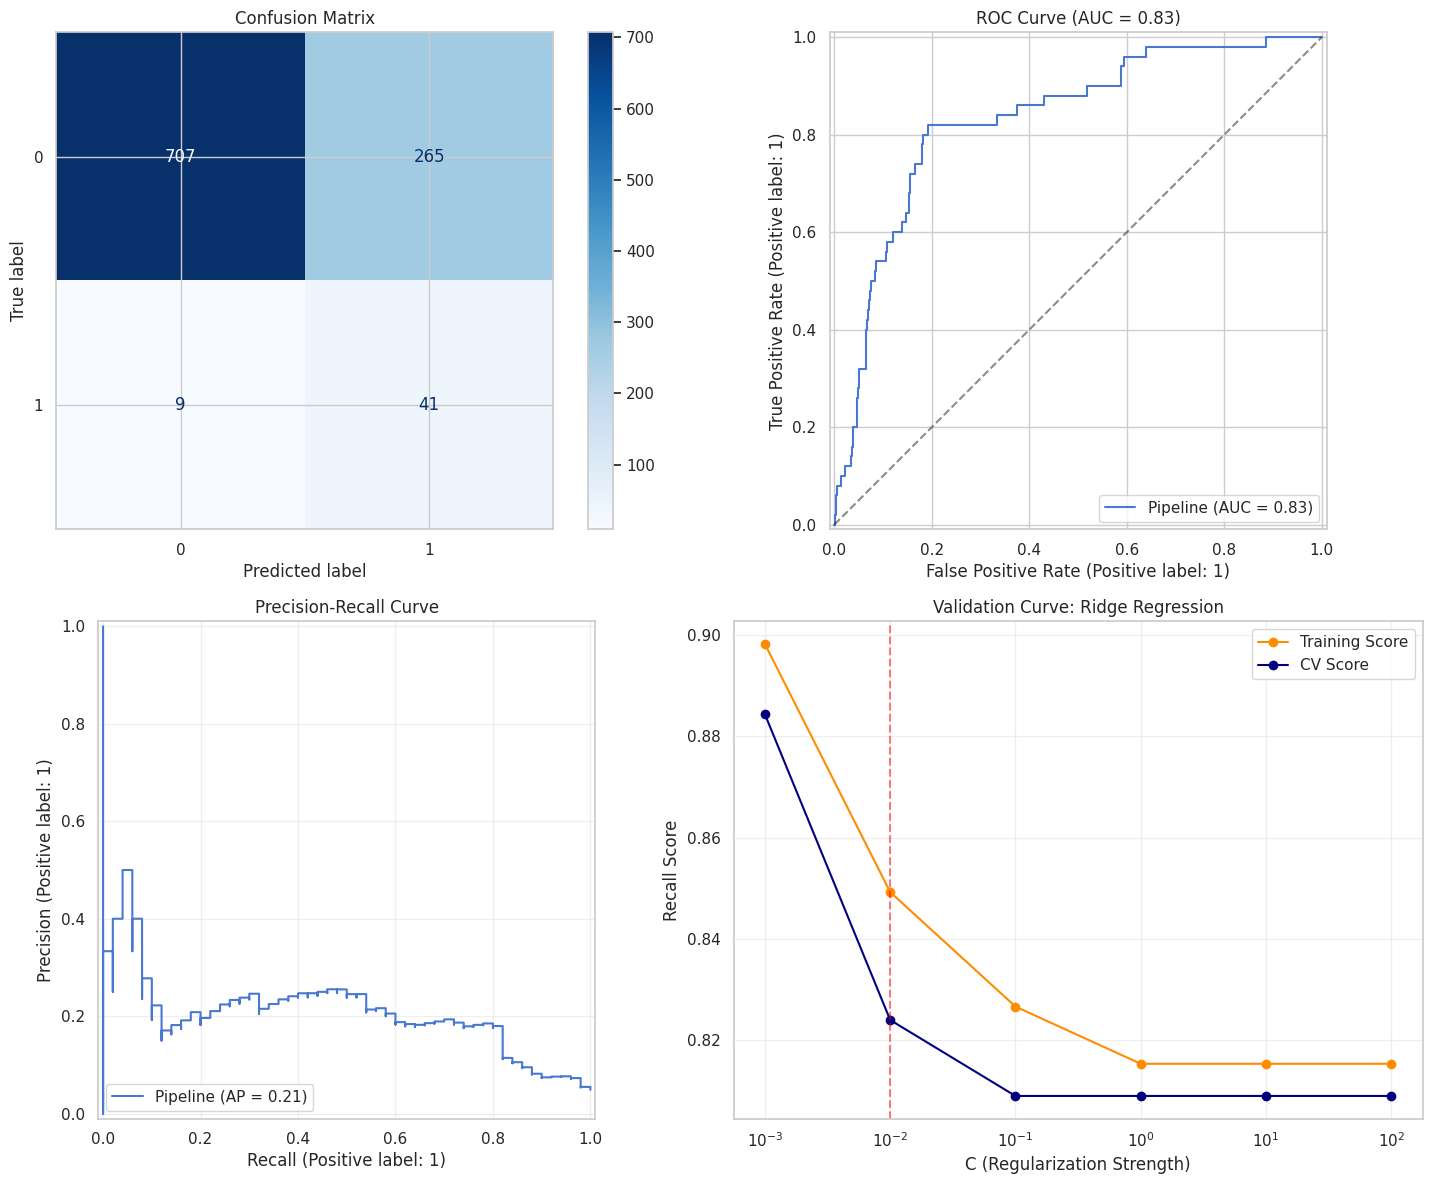

In [ ]:
SELECTED_RANK = 0 #---> chosen model

selected_row = results_df.iloc[SELECTED_RANK]
model_name = selected_row['Model']
best_params = selected_row['Params']

print(f"\n ANALYZING CHOSEN MODEL: {model_name}")
print(f"Using Parameters: {best_params}")

if "Logistic" in model_name: final_model = pipe_logit
elif "Ridge" in model_name: final_model = pipe_ridge
elif "Elastic" in model_name: final_model = pipe_elastic
elif "Random Forest" in model_name: final_model = pipe_rf
elif "XGBoost" in model_name: final_model = pipe_xgb


final_model.set_params(**best_params)
final_model.fit(X_train, y_train)


# Test Set Metrics:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\n TEST SET PERFORMANCE")
print(f"Recall:       {recall_score(y_test, y_pred):.4f}")
print(f"Precision:    {precision_score(y_test, y_pred):.4f}")
print(f"ROC AUC:      {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred):.4f}")


# Diagnostic Plots:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix (Top Left)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=axes[0,0])
axes[0,0].set_title("Confusion Matrix")

# 2. ROC Curve (Top Right)
RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=axes[0,1])
axes[0,1].set_title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

# 3. Precision-Recall Curve (Bottom Left)
PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, ax=axes[1,0])
axes[1,0].set_title("Precision-Recall Curve")
axes[1,0].grid(True, alpha=0.3)

# 4. Validation Curve (Hyperparameter Tuning Curve)
print("\nGenerating Validation Curve for stability check...")

if "XGBoost" in model_name or "Random Forest" in model_name:
    param_name = "model__max_depth"
    param_range = [2, 4, 6, 8, 10, 12]
    x_label = "Max Depth"
    use_log_scale = False
elif "Elastic" in model_name:
    param_name = "model__l1_ratio"
    param_range = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    x_label = "L1 Ratio (0=Ridge, 1=Lasso)"
    use_log_scale = False
else: # Ridge or Logistic
    param_name = "model__C"
    param_range = [0.001, 0.01, 0.1, 1, 10, 100]
    x_label = "C (Regularization Strength)"
    use_log_scale = True

train_scores, valid_scores = validation_curve(
    final_model, X_train, y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5, scoring="recall", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

axes[1,1].plot(param_range, train_mean, label="Training Score", color="darkorange", marker='o')
axes[1,1].plot(param_range, valid_mean, label="CV Score", color="navy", marker='o')
axes[1,1].set_title(f"Validation Curve: {model_name}")
axes[1,1].set_xlabel(x_label)
axes[1,1].set_ylabel("Recall Score")
axes[1,1].legend(loc="best")
axes[1,1].grid(True, alpha=0.3)

if use_log_scale:
    axes[1,1].set_xscale('log')

current_param_val = best_params.get(param_name)
if current_param_val in param_range:
    axes[1,1].axvline(x=current_param_val, color='red', linestyle='--', alpha=0.5, label='Selected Value')

plt.tight_layout()
plt.show()

# 5. Interpretation

We analyze the feature importances (or coefficients) to understand what drives the predictions.

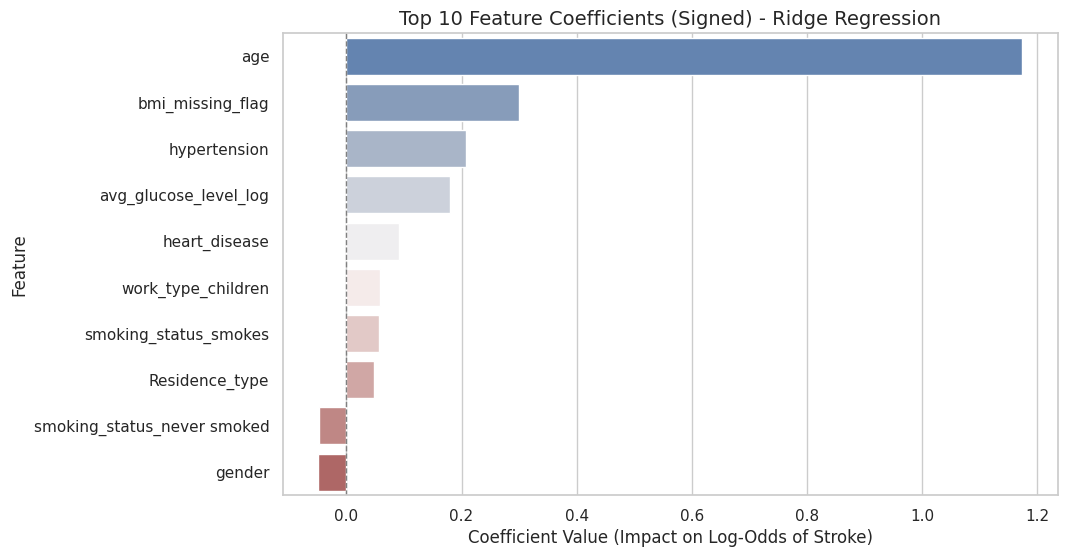


Top 3 Most Influential Features (by Coefficient Magnitude):
1.  age  (Coefficient: 1.1743)
2.  bmi_missing_flag  (Coefficient: 0.2994)
3.  hypertension  (Coefficient: 0.2085)


In [ ]:
TOP_N_FEATURES = 10

model_step = final_model.named_steps['model']
coefs = model_step.coef_[0] if model_step.coef_.ndim > 1 else model_step.coef_
N_COEFS = len(coefs)


feature_names_expanded = X_train.columns.tolist()

coef_series = pd.Series(coefs, index=feature_names_expanded)

feat_imp_indices = coef_series.abs().sort_values(ascending=False).head(TOP_N_FEATURES).index


plot_data = coef_series.loc[feat_imp_indices].sort_values(ascending=False).reset_index()
plot_data.columns = ['Feature', 'Metric']
title = f"Top {TOP_N_FEATURES} Feature Coefficients (Signed) - {model_name}"
xlabel = "Coefficient Value (Impact on Log-Odds of Stroke)"
plt.figure(figsize=(10, 6))
sns.barplot(x=plot_data['Metric'], y=plot_data['Feature'], palette='vlag')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.title(title, fontsize=14)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()


top_3_features = coef_series.loc[feat_imp_indices].abs().sort_values(ascending=False).head(3).index.tolist()
print("\nTop 3 Most Influential Features (by Coefficient Magnitude):")
for rank, feature in enumerate(top_3_features):
    signed_coef = coef_series.loc[feature]
    print(f"{rank + 1}.  {feature}  (Coefficient: {signed_coef:.4f})")